We will try to forecast the maximum monthly temperature in Madrid in 2024.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
pip install meteostat

In [3]:
from meteostat import Point, Monthly

start = datetime(1970, 3, 1)
end = datetime.now()

# Create Point for Madrid
location = Point(40.416775, -3.703790, 657)

df_madrid = Monthly(location, start, end)
df_madrid = df_madrid.fetch()

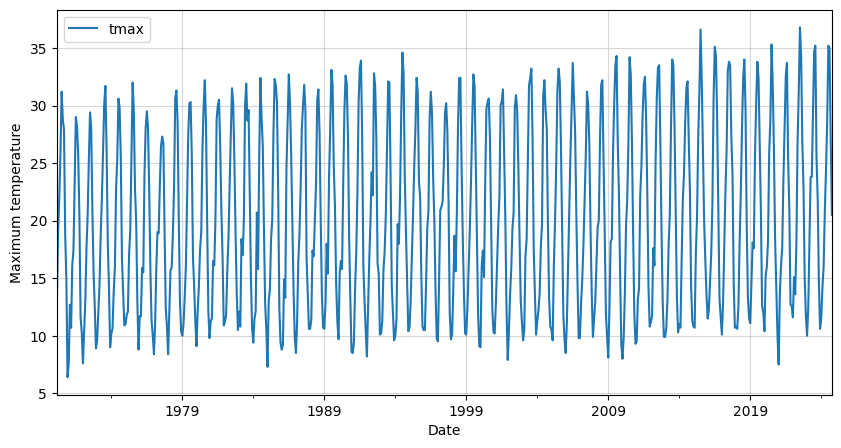

In [4]:
df_temp_max = df_madrid[['tmax']]

df_temp_max.plot(figsize=(10,5))
plt.grid(alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

In [5]:
df_temp_max.isna().sum()

,0
tmax,0


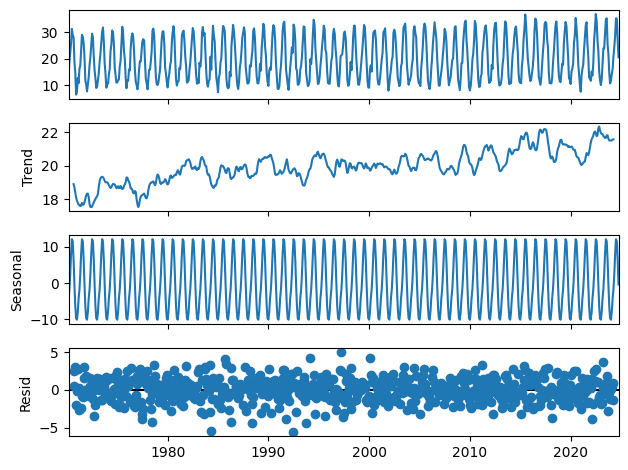

In [6]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_temp_max,
                                          model='additive',
                                          period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

Check for stationiarity

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_temp_max)

test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -3.016746910363927
P-value: 0.03335977201123731


We got a p-value lower than 0.05, therefore, we can assume that our data is stationary.

Check for seasonality and the seasonal period.

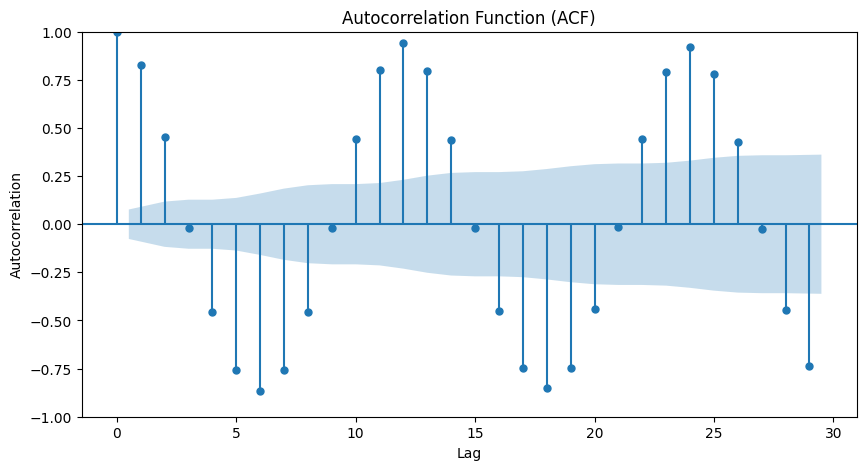

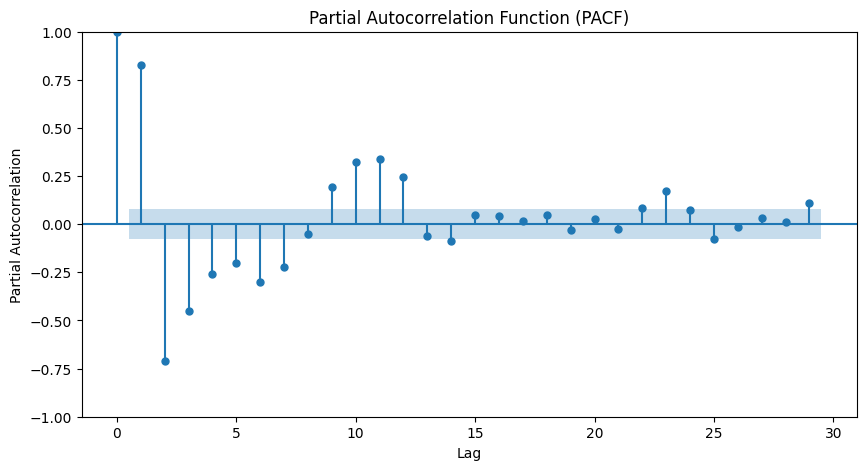

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

Train - Test split

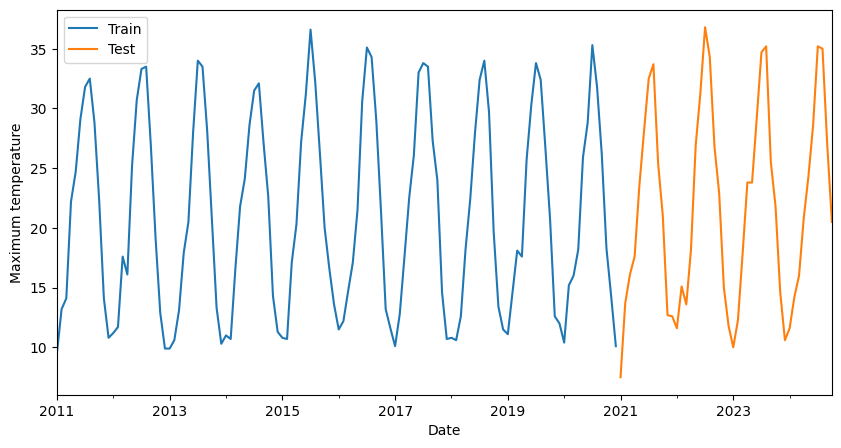

In [9]:
df_train = df_temp_max.loc[:'2020']
df_test = df_temp_max.loc['2021':]

ax = df_train[-12*10:].plot(figsize=(10, 5))
df_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

Optimizing model for minimum value of AIC (Akaike Information Criterion)

In [10]:
import itertools
import math

p_values = range(0, 3)
d_values = [0]
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 1)
Q_values = range(0, 2)
m_values = [12]

param_combinations = list(itertools.product(p_values,
                                            d_values,
                                            q_values,
                                            P_values,
                                            D_values,
                                            Q_values,
                                            m_values))

best_aic = float("inf")
best_params = None

for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = sm.tsa.SARIMAX(df_train,
                               order=order,
                               seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)

            if aic < best_aic:
                best_aic = aic
                best_params = params

        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(0, 0, 0) (0, 0, 0, 12) 5471.171017366447
(0, 0, 0) (0, 0, 1, 12) 4755.531108034584
(0, 0, 0) (1, 0, 0, 12) 2807.0375681291594


(0, 0, 0) (1, 0, 1, 12) 2495.6637155399494
(0, 0, 1) (0, 0, 0, 12) 4738.463525441704


(0, 0, 1) (0, 0, 1, 12) 4158.492845797668


(0, 0, 1) (1, 0, 0, 12) 2774.9066952444036


(0, 0, 1) (1, 0, 1, 12) 2464.783329132571


(0, 0, 2) (0, 0, 0, 12) 4243.935235475042


(0, 0, 2) (0, 0, 1, 12) 3882.0060978961883


(0, 0, 2) (1, 0, 0, 12) 2766.7676303487788


(0, 0, 2) (1, 0, 1, 12) 2458.64124234991
(1, 0, 0) (0, 0, 0, 12) 3608.635193188629
(1, 0, 0) (0, 0, 1, 12) 3288.467753938839
(1, 0, 0) (1, 0, 0, 12) 2768.194058251096


(1, 0, 0) (1, 0, 1, 12) 2457.7094314271117
(1, 0, 1) (0, 0, 0, 12) 3435.3925302674843
(1, 0, 1) (0, 0, 1, 12) 3250.5367591675194
(1, 0, 1) (1, 0, 0, 12) 2768.3590288532014


(1, 0, 1) (1, 0, 1, 12) 2463.0185030237662
(1, 0, 2) (0, 0, 0, 12) 3346.231814763745
(1, 0, 2) (0, 0, 1, 12) 3200.8842293756393


(1, 0, 2) (1, 0, 0, 12) 2751.491864594219
(2, 0, 0) (0, 0, 0, 12) 3350.2113890997516
(2, 0, 0) (0, 0, 1, 12) 3225.0056253305474
(2, 0, 0) (1, 0, 0, 12) 2767.658125604309


(2, 0, 0) (1, 0, 1, 12) 2456.9604789193227
(2, 0, 1) (0, 0, 0, 12) 3352.211383784052
(2, 0, 1) (0, 0, 1, 12) 3220.6412732930767
(2, 0, 1) (1, 0, 0, 12) 2772.1172415244637


(2, 0, 1) (1, 0, 1, 12) 2438.1227182180937
(2, 0, 2) (0, 0, 0, 12) 3313.111787644789
(2, 0, 2) (0, 0, 1, 12) 3188.875372295329
(2, 0, 2) (1, 0, 0, 12) 2770.9205288173216


(2, 0, 2) (1, 0, 1, 12) not converged
Best Parameters: (2, 0, 1, 1, 0, 1, 12)
Best AIC: 2438.1227182180937


Best Parameters: (2, 0, 1, 1, 0, 1, 12)



Best AIC: 2438.1227182180937



SARIMAX Model

In [11]:
model = sm.tsa.SARIMAX(df_train,
                       order=best_params[:3],
                       seasonal_order=best_params[3:])
result = model.fit(disp=False)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               tmax   No. Observations:                  610
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1213.061
Date:                            Mon, 02 Dec 2024   AIC                           2438.123
Time:                                    05:25:03   BIC                           2464.603
Sample:                                03-01-1970   HQIC                          2448.424
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2276      0.011    115.037      0.000       1.207       1.248
ar.L2         -0.2296      0.009    -24.527      0.000      -0.248      -0.211
ma.L1         -0.9893      0.012    -84.680      0.000      -1.012      -0.966
ar.S.L12       0.9992      0.000   2144.925      0.000       0.998       1.000
ma.S.L12      -0.8615      0.022    -38.887      0.000      -0.905      -0.818
sigma2         2.8157      0.122     23.073      0.000       2.577       3.055
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.50
Prob(Q):                              0.96   Prob(JB):                         0.17
Heteroskedasticity (H):               0.75   Skew:                            -0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plotting forecast

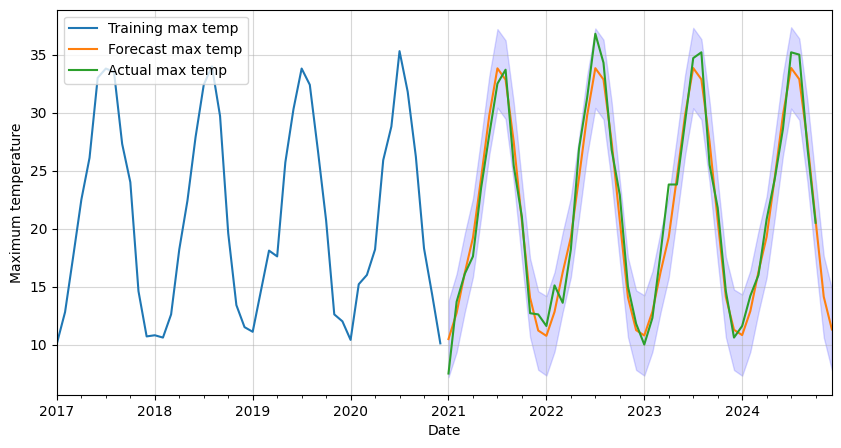

In [13]:
current_date = datetime.now()
last_date_in_training = df_train.index[-1]

num_months = (current_date.year - last_date_in_training.year) * 12 + (current_date.month - last_date_in_training.month)

forecast = result.get_forecast(steps=num_months)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

ax = df_train[-12*4:].plot(figsize=(10,5))
forecast_values.plot(ax=ax)
df_test.plot(ax=ax)

plt.fill_between(forecast_values.index,
                 confidence_intervals['lower tmax'],
                 confidence_intervals['upper tmax'],
                 color='blue',
                 alpha=0.15)

plt.legend(['Training max temp',
            'Forecast max temp',
            'Actual max temp'],
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()